# Loading in xray data from exp (55Fe x-rays on SCA 20663)

In [1]:
# Turn ON notebook and OFF inline and ipympl when running on OSC
#%matplotlib notebook  
%matplotlib inline 
%matplotlib ipympl

import os
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import label
from scipy.ndimage import maximum_filter
from astropy.stats import sigma_clipped_stats
from concurrent.futures import ProcessPoolExecutor, as_completed
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.ndimage import label
from pathlib import Path

try:
    here = Path(__file__).parent
except NameError:
    # __file__ doesn't exist in notebooks or interactive sessions
    here = Path.cwd()
fits_path = here / '20190919_95k_1p1m0p1_fe55_20663_003_diff.fits'  # ← replace with your actual filename

with fits.open(fits_path) as hdulist:
    # hdulist is a list of HDU (Header/Data Unit) objects
    primary_hdu = hdulist[0]
    data = primary_hdu.data      # NumPy array of your image/spectrum/whatever
    header = primary_hdu.header  # FITS header metadata

print(f"Data shape: {data.shape}")
print("Header keys:", list(header.keys())[:10])


C:\Users\Owner\anaconda3\envs\8820-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data shape: (100, 4096, 4096)
Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND']


In [8]:
#enter number of available cores
num_of_cores = os.cpu_count() + 4

#data dimensions
Nframe, h, w = data.shape

def compute_mask_med_frame(data, sigma_mult):
    print("⏳ Computing median-frame mask…")
    median_img = np.median(data, axis=0)
    mad        = np.median(np.abs(median_img - np.median(median_img)))
    sigma_est  = 1.4826 * mad
    thresh_med = np.median(median_img) + sigma_mult * sigma_est
    mask_med   = median_img > thresh_med
    print(f"✅ Done median-frame mask (σ={sigma_est:.3f}, thresh={thresh_med:.1f})")
    return mask_med

def compute_mask_first_frame(data, sigma_mult):
    print("⏳ Computing first-slice mask…")
    first_img  = data[0]
    med_first  = np.median(first_img)
    mad_first  = np.median(np.abs(first_img - med_first))
    sigma_est  = 1.4826 * mad_first
    thresh0    = med_first + sigma_mult * sigma_est
    mask0      = first_img > thresh0
    print(f"✅ Done first-slice mask (σ={sigma_est:.3f}, thresh={thresh0:.1f})")
    return mask0

def compute_mask_saturation(data, sat_cut):
    print("⏳ Computing saturation-diff mask…")
    # If you wanted a row-wise tqdm you could replace the next line with a loop + tqdm
    frame_diff = np.abs(np.diff(data, axis=0))       # (Nframe-1, 4096,4096)
    med_diff   = np.median(frame_diff, axis=0)
    mask_sat   = med_diff < sat_cut
    print(f"✅ Done sat-diff mask (median(med_diff)={np.median(med_diff):.3e})")
    return mask_sat

# parameters
sigma_mult = 2.5
sat_cut     = 1e-3

# launch all three in parallel
with ThreadPoolExecutor(max_workers=num_of_cores) as exe:
    futures = {
        exe.submit(compute_mask_med_frame,  data, sigma_mult): 'med',
        exe.submit(compute_mask_first_frame, data, sigma_mult): 'first',
        exe.submit(compute_mask_saturation, data, sat_cut):     'sat',
    }
    # just iterate to let each print when done
    for fut in as_completed(futures):
        _name = futures[fut]
        # could inspect fut.result() here if you wanted to check for errors

# pull results out
mask_med = futures_inv = None
mask_med = futures_inv = None
mask_med = None
# unfortunately there's no built-in mapping back, so:
mask_med = [f for f,n in futures.items() if n=='med'][0].result()
mask0    = [f for f,n in futures.items() if n=='first'][0].result()
mask_sat = [f for f,n in futures.items() if n=='sat'][0].result()

print("🔗 Combining masks into one boolean array…")
maskArray = mask_med | mask0 | mask_sat
print("🎉 maskArray ready, shape =", maskArray.shape)

⏳ Computing median-frame mask…
⏳ Computing first-slice mask…
⏳ Computing saturation-diff mask…
✅ Done first-slice mask (σ=8.896, thresh=21.2)
✅ Done median-frame mask (σ=0.741, thresh=1.9)
✅ Done sat-diff mask (median(med_diff)=1.000e+01)
🔗 Combining masks into one boolean array…
🎉 maskArray ready, shape = (4096, 4096)


saturators =  138506
persistent warms =  244394
early saturators =  6


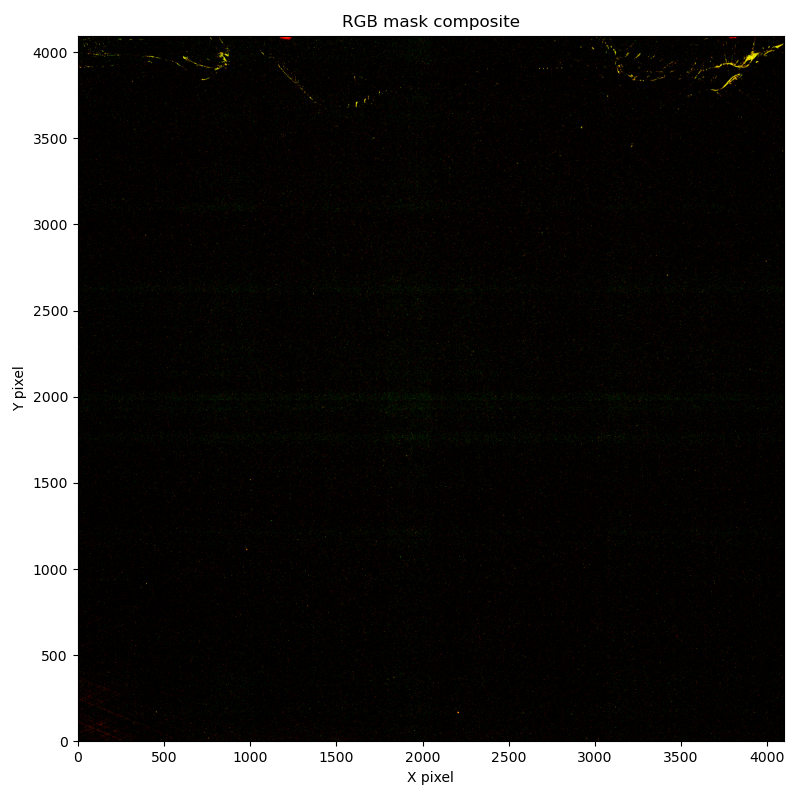

In [9]:
print("saturators = ", np.count_nonzero(mask0))
print("persistent warms = ", np.count_nonzero(mask_med))
print("early saturators = ", np.count_nonzero(mask_sat))

# mask_med picks out pixels whose time‑median is high (persistent warms)
# mask0 catches pixels that fire instantly and then go dead (saturators)
# mask_sat (optional) flags pixels whose frame‑to‑frame change is
#   vanishingly, small—another way to spot early‐saturators 

# build the RGB composite
rgb_mask = np.zeros((h, w, 3), dtype=float)

rgb_mask[..., 0] = mask_med.astype(float)   # red channel
rgb_mask[..., 1] = mask0.astype(float)      # green channel
rgb_mask[..., 2] = mask_sat.astype(float)   # blue channel

plt.figure(figsize=(8,8))
plt.imshow(rgb_mask, origin='lower')
plt.title("RGB mask composite")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.tight_layout()
plt.show()

#plt.figure(figsize=(8,8))
#plt.imshow(maskArray, cmap='gray_r', origin='lower')
#plt.title("Hot/warm‑pixel mask")
#plt.xlabel("X pixel")
#plt.ylabel("Y pixel")
#plt.tight_layout()
#plt.show()

Found 15482 xray & cosmic‐ray‐like peaks with ≥20.0 σ cut (per-frame thresholds below):


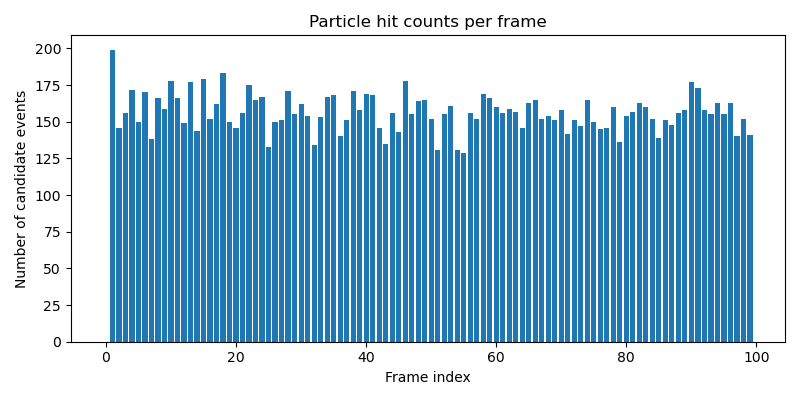

In [10]:
sigma_thresh   = 20.0
mask_expanded  = maximum_filter(maskArray.astype(int), size=5) > 0

def find_peaks_for_frame(iframe, sigma_thresh):
    image   = data[iframe]
    _, med, _ = sigma_clipped_stats(image, sigma=3.0, maxiters=5)
    mad     = np.median(np.abs(image - med))
    sigma_e = mad * 1.4826
    threshold = med + sigma_thresh * sigma_e

    local_max = maximum_filter(image, size=3)
    cand      = (image == local_max) & (~mask_expanded) & (image > threshold)

    ys, xs = np.where(cand)
    peaks  = [(iframe, int(y), int(x)) for y, x in zip(ys, xs)]
    return peaks, threshold

if __name__ == "__main__":

    # 1) run in parallel, get a list of (peaks, threshold) tuples
    with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
        results = list(executor.map(
            find_peaks_for_frame,
            range(Nframe),
            [sigma_thresh] * Nframe
        ))

    # 2) unzip them into two lists
    all_frame_peaks, thresholds = zip(*results)
    #    all_frame_peaks is a tuple of length Nframe, each entry is the peaks list
    #    thresholds        is a tuple of length Nframe, each entry is that frame’s threshold

    # 3) now do your “previous‐frame” filtering exactly as before
    filtered_events = []
    for f, peaks in enumerate(all_frame_peaks):
        prev_f = (f - 1) % Nframe
        prev_pos = {(y, x) for (_, y, x) in all_frame_peaks[prev_f]}
        for (_, y, x) in peaks:
            if (y, x) not in prev_pos:
                filtered_events.append((f, y, x))

    events = np.array(filtered_events, dtype=int)
    print(f"Found {len(events)} xray & cosmic‐ray‐like peaks "
          f"with ≥{sigma_thresh:.1f} σ cut (per-frame thresholds below):")

    # 4) if you want, print out each frame’s threshold:
    #for f, thr in enumerate(thresholds):
        #print(f"  frame {f:3d}: threshold = {thr:.1f}")

        # count how many hits in each frame
counts = np.bincount(events[:,0], minlength=data.shape[0])

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(counts)), counts)
plt.xlabel("Frame index")
plt.ylabel("Number of candidate events")
plt.title("Particle hit counts per frame")
plt.tight_layout()
plt.show()

In [ ]:
low_threshold = 0.5 * sigma_thresh

# Freudenburg et al. gain
gain = 1.6232  # electrons per DN

def prep_frame(f):
    """Compute median background, sigma_est, and labels for frame f."""
    img = data[f].astype(np.float64)
    _, med, _ = sigma_clipped_stats(img, sigma=3.0, maxiters=5)
    mad       = np.median(np.abs(img - med))
    sigma_est = mad * 1.4826
    thresh    = med + low_threshold * sigma_est
    labels_fp, _ = label(img > thresh)
    return f, med, labels_fp

def process_hit(hit):
    """Given one (f, y, x) hit, compute all sums and return a dict."""
    f, y, x      = hit
    img          = data[f].astype(np.int32)
    med          = medians[f]
    labels_fp    = labels_list[f]

    # 3×3 window
    y0,  y1     = max(y-1,0), min(y+2,h)
    x0,  x1     = max(x-1,0), min(x+2,w)
    sum3        = img[y0:y1, x0:x1].sum()

    # 5×5 window
    y0_5, y1_5 = max(y-2,0), min(y+3,h)
    x0_5, x1_5 = max(x-2,0), min(x+3,w)
    sum5        = img[y0_5:y1_5, x0_5:x1_5].sum()

    # footprint sum
    lab         = labels_fp[y, x]
    region      = (labels_fp == lab)
    sum_fp_DN   = img[region].sum() - med * region.sum()

    return {
        'frame':      f,
        'y':          y,
        'x':          x,
        'sum3x3_DN':  int(sum3),
        'sum3x3_e⁻':  sum3 * gain,
        'sum5x5_DN':  int(sum5),
        'sum5x5_e⁻':  sum5 * gain,
        'fp_label':   lab,
        'fp_DN':      int(sum_fp_DN),
        'fp_e⁻':      sum_fp_DN * gain,
        'n_pix_fp':   int(region.sum()),
    }

if __name__ == '__main__':
    # 1) Parallel frame prep
    medians     = np.zeros(Nframe, dtype=float)
    labels_list = [None] * Nframe

    with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
        futures = [executor.submit(prep_frame, f) for f in range(Nframe)]
        for fut in as_completed(futures):
            f, med, labels_fp = fut.result()
            medians[f]    = med
            labels_list[f] = labels_fp

    # 2) Parallel hit processing
    rows = []
    with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
        # adjust n_workers = os.cpu_count() if you like
        for result in executor.map(process_hit, events):
            rows.append(result)

    # 3) Build DataFrame & plot
    df = pd.DataFrame(rows)
    print(df.head())


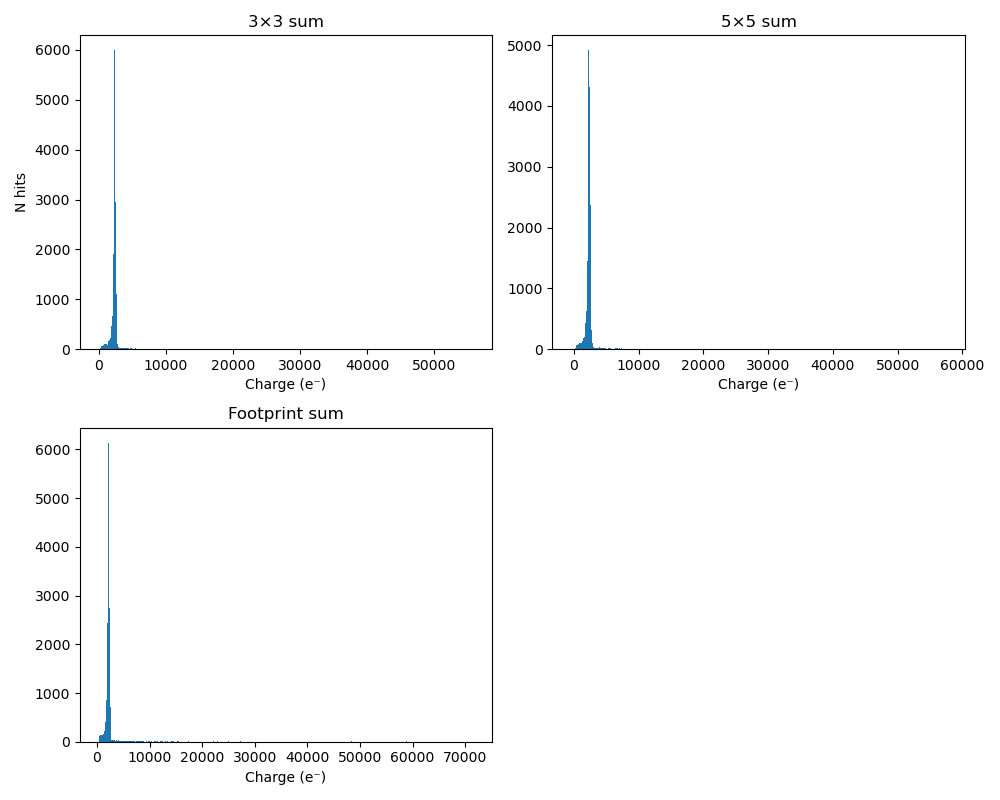

In [7]:
# --- 4) Plot histograms in 2 rows × 2 cols ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()   # makes it easy to index: axes[0], axes[1], axes[2], axes[3]

# 3×3 sum
axes[0].hist(df['sum3x3_e⁻'], bins=500)
axes[0].set(title='3×3 sum', xlabel='Charge (e⁻)', ylabel='N hits')

# 5×5 sum
axes[1].hist(df['sum5x5_e⁻'], bins=500)
axes[1].set(title='5×5 sum', xlabel='Charge (e⁻)')

# Footprint sum
axes[2].hist(df['fp_e⁻'], bins=500)
axes[2].set(title='Footprint sum', xlabel='Charge (e⁻)')

# Turn off the empty fourth subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


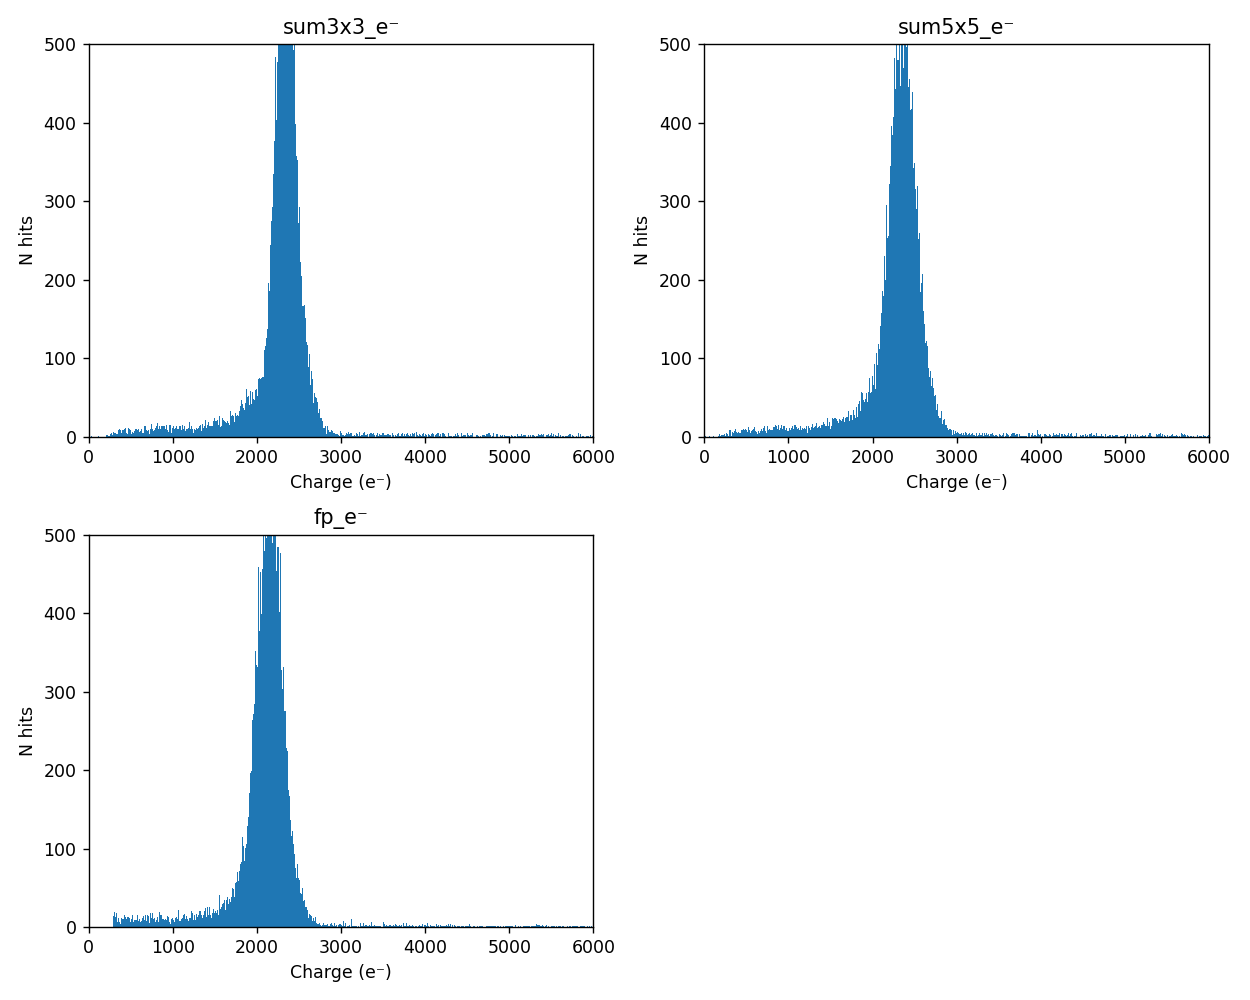

In [7]:
# define your desired x– and y–limits
x_min, x_max = 0, 6000
y_min, y_max = 0, 500

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# first three plots, each clipped to [0,2000] on x and [0,100] on y
for ax, col in zip(axes[:3], ['sum3x3_e⁻', 'sum5x5_e⁻', 'fp_e⁻']):
    ax.hist(df[col], bins=500, range=(x_min, x_max))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Charge (e⁻)')
    ax.set_ylabel('N hits')
    ax.set_title(col)

# turn off the empty fourth subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()


Mean       = 2151.28 DN
σ          = 163.45 DN
FWHM       = 384.90 DN


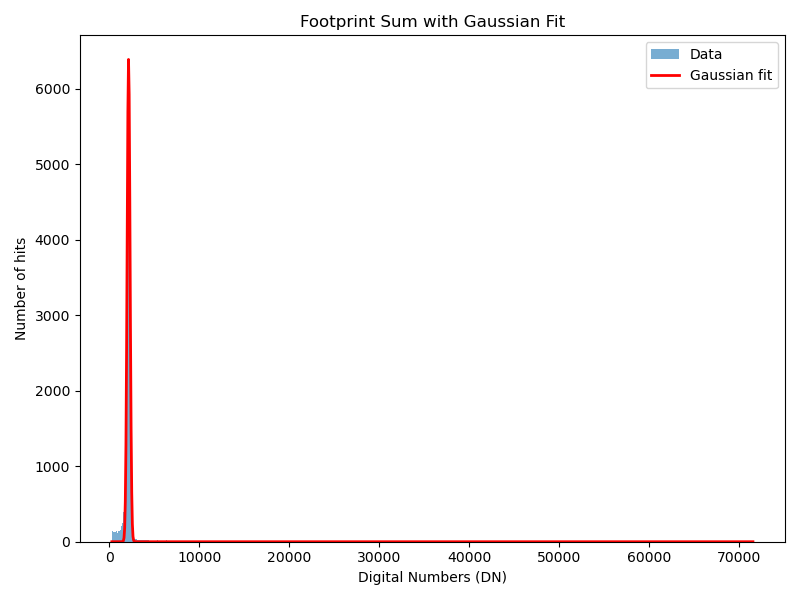

In [27]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Extract footprint data
fp_data = df['fp_e⁻'].values

# Make histogram bins
counts, bin_edges = np.histogram(fp_data, bins=500)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Initial parameter guesses [amplitude, mean, sigma]
p0 = [counts.max(), fp_data.mean(), fp_data.std()]

# Fit Gaussian → popt = [A_fit, mu_fit, sigma_fit]
popt, _ = opt.curve_fit(gaussian, bin_centers, counts, p0=p0)
A_fit, mu_fit, sigma_fit = popt
sigma_fit = np.abs(sigma_fit)

# Compute FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
print(f"Mean       = {mu_fit:.2f} DN")
print(f"σ          = {sigma_fit:.2f} DN")
print(f"FWHM       = {fwhm:.2f} DN")

# Plot the histogram + fit
plt.figure(figsize=(8, 6))
plt.hist(fp_data, bins=500, alpha=0.6, label='Data')
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', lw=2, label='Gaussian fit')

plt.title('Footprint Sum with Gaussian Fit')
plt.xlabel('Digital Numbers (DN)')
plt.ylabel('Number of hits')
plt.legend()
plt.tight_layout()
plt.show()


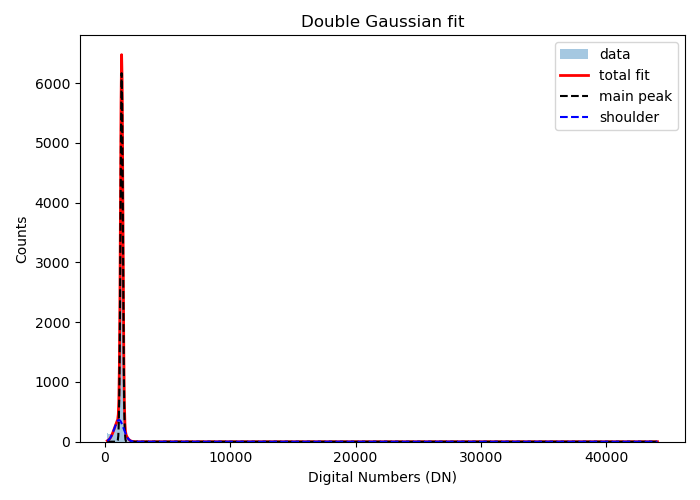

Total fit FWHM = 228.99 DN


In [25]:
def double_gauss(x, A1, μ1, σ1, A2, μ2, σ2):
    g1 = A1 * np.exp(-0.5*((x-μ1)/σ1)**2)
    g2 = A2 * np.exp(-0.5*((x-μ2)/σ2)**2)
    return g1 + g2

# histogram
counts, edges = np.histogram(fp_data, bins=500)
centers = 0.5*(edges[:-1]+edges[1:])

# initial guesses: main peak near mean, shoulder offset to the right
p0 = [
  counts.max(), fp_data.mean(), fp_data.std(),
  counts.max()/4, fp_data.mean()+2*fp_data.std(), fp_data.std()
]

popt, _ = opt.curve_fit(double_gauss, centers, counts, p0=p0,
                        bounds=([0,-np.inf,0,  0,-np.inf,0],
                                [np.inf,np.inf,np.inf, np.inf,np.inf,np.inf]))
# extract main‐peak σ and FWHM
σ_main = abs(popt[2])
fwhm_main = 2*np.sqrt(2*np.log(2))*σ_main

# plot
x = np.linspace(edges[0], edges[-1], 1000)
plt.figure(figsize=(7,5))
plt.hist(fp_data, bins=500, alpha=0.4, label="data")
plt.plot(x, double_gauss(x,*popt), 'r-', lw=2, label="total fit")
# overlay individual components
plt.plot(x, popt[0]*np.exp(-0.5*((x-popt[1])/popt[2])**2),
         'k--', label="main peak")
plt.plot(x, popt[3]*np.exp(-0.5*((x-popt[4])/popt[5])**2),
         'b--', label="shoulder")
plt.legend()
plt.xlabel('Digital Numbers (DN)')
plt.ylabel('Counts')
plt.title("Double Gaussian fit")
plt.tight_layout()
plt.show()


# 1) Build a fine x-grid and evaluate the total fit
x_fit = np.linspace(edges[0], edges[-1], 10000)
y_fit = double_gauss(x_fit, *popt)

# 2) Compute half‐max
y_max  = y_fit.max()
y_half = y_max / 2.0

# 3) Find index of the peak
idx_peak = np.argmax(y_fit)

# 4) March left from the peak until we drop below half‐max
i = idx_peak
while i > 0 and y_fit[i] > y_half:
    i -= 1
# linear interp between (i, i+1) to find exact crossing
x_left = x_fit[i] + (y_half - y_fit[i]) * (x_fit[i+1] - x_fit[i]) / (y_fit[i+1] - y_fit[i])

# 5) March right from the peak until we drop below half‐max
j = idx_peak
while j < len(y_fit)-1 and y_fit[j] > y_half:
    j += 1
x_right = x_fit[j-1] + (y_half - y_fit[j-1]) * (x_fit[j] - x_fit[j-1]) / (y_fit[j] - y_fit[j-1])

# 6) Compute total FWHM
fwhm_total = x_right - x_left
print(f"Total fit FWHM = {fwhm_total:.2f} DN")


In [26]:
#finding Fano Factor from raw data and also gaussian fit
# 1) From the raw data:
mean_data = fp_data.mean()
var_data  = fp_data.var(ddof=0)    # population variance
fano_data = (var_data / mean_data) - 1

# 2) From the Gaussian fit:
mean_fit = mu_fit
var_fit  = sigma_fit**2
fano_fit = (var_fit / mean_fit) - 1

print(f"Data:   ⟨N⟩ = {mean_data:.2f}, Var = {var_data:.2f}, Fano = {fano_data:.3f}")
print(f"Fit:    ⟨N⟩ = {mean_fit:.2f}, Var = {var_fit:.2f}, Fano = {fano_fit:.3f}")


Data:   ⟨N⟩ = 1552.24, Var = 3885105.58, Fano = 2501.905
Fit:    ⟨N⟩ = 1325.34, Var = 10140.15, Fano = 6.651


In [ ]:
#fit a gaussian to the histograms

In [ ]:
def get_cr_hits_for_frame(df, frame_idx):
    """
    Return a DataFrame of all cosmic-ray hits in a given frame.

    Parameters
    ----------
    df : pandas.DataFrame
        Your full table with at least a 'frame' column.
    frame_idx : int
        The frame number you want to filter on.

    Returns
    -------
    pandas.DataFrame
        Subset of df where df['frame'] == frame_idx, with a fresh index.
    """
    sub = df[df['frame'] == frame_idx].copy()
    return sub.reset_index(drop=True)

# Suppose df is your full CR-hit table:
inspect_frame = 61
hits_from_frame = get_cr_hits_for_frame(df, inspect_frame)
print(hits_from_frame)


Original dataframe had  21524  candidate entries
New dataframe has  21425  candidate entries, 99  were duplicates


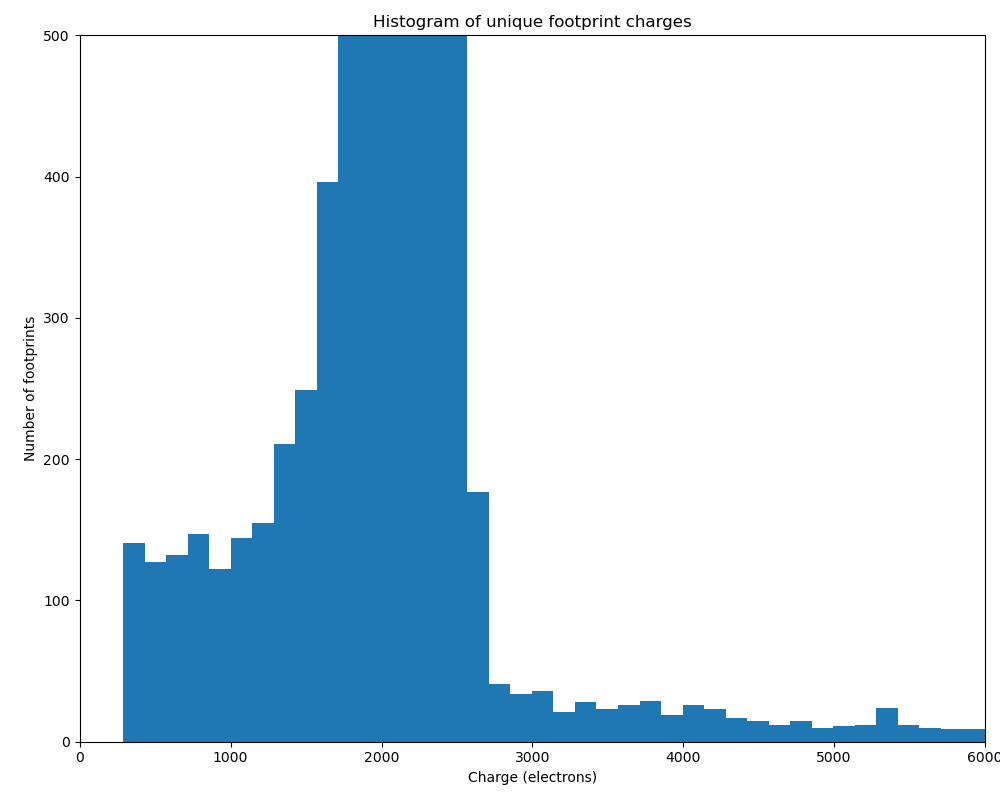

In [29]:
df_unique = df.drop_duplicates(subset=['frame','fp_label'])

# define your desired x– and y–limits
x_min, x_max = 0, 6000
y_min, y_max = 0, 500

print("Original dataframe had ",len(df)," candidate entries")
difference = len(df) - len(df_unique)
print("New dataframe has ",len(df_unique)," candidate entries,", difference, " were duplicates")

plt.figure(figsize=(10,8))
plt.hist(df_unique['fp_e⁻'], bins=500)
plt.xlabel('Charge (electrons)')
plt.ylabel('Number of footprints')
plt.title('Histogram of unique footprint charges')
plt.tight_layout()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()


In [30]:
inspect_frame = 61

# 1) grab the image and build your RGB mask as before
img = data[inspect_frame]

rgb_mask = np.zeros((h, w, 3), dtype=float)
rgb_mask[..., 0] = mask_med.astype(float)
rgb_mask[..., 1] = mask0.astype(float)
rgb_mask[..., 2] = mask_sat.astype(float)

# Instead just fetch:
median    = medians[inspect_frame]
labels_fp = labels_list[inspect_frame]

# 4) select only the hits in this frame
mask_frame = (events[:, 0] == inspect_frame)
ys, xs     = events[mask_frame, 1], events[mask_frame, 2]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap='gray', origin='lower')
ax.imshow(rgb_mask, origin='lower')

# contour each labeled footprint using a tight bounding box
for lab in np.unique(labels_fp):
    if lab == 0:
        continue

    # find all pixels belonging to this label
    ys_lab, xs_lab = np.where(labels_fp == lab)
    y0, y1 = ys_lab.min(), ys_lab.max()
    x0, x1 = xs_lab.min(), xs_lab.max()

    # crop to just that region and build a binary mask
    region = (labels_fp[y0:y1+1, x0:x1+1] == lab).astype(int)

    # contour the small patch, mapping it back onto the full axes
    ax.contour(
        region,
        levels=[0.5],
        colors='white',
        linewidths=1.5,
        origin='lower',
        extent=(x0, x1+1, y0, y1+1)
    )

# re-plot centroids on top
ax.scatter(xs, ys, s=20, c='red', label=f"{len(xs)} hits", edgecolor='black')
ax.legend(loc='upper right')
ax.set_xlim(0, img.shape[1])
ax.set_ylim(0, img.shape[0])
plt.show()


MemoryError: Unable to allocate 16.0 MiB for an array with shape (4096, 4096) and data type bool

MemoryError: Unable to allocate 64.0 MiB for an array with shape (4096, 4096) and data type float32

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

In [ ]:
# 1) Build df_unique (one row per footprint)
#    Make sure your original df has a column 'fp_label'
#df_unique = df.drop_duplicates(subset=['frame','fp_label'])

# 2) Compute centroids of each footprint
centroids = (
    df_unique
      .groupby(['frame','fp_label'])
      .agg(x_centroid=('x','mean'),
           y_centroid=('y','mean'))
      .reset_index()
)

In [ ]:
# 1) Using direct indexing
#df_filtered = df[df['n_pix_fp'] > 10]

# 2) Using .loc
#df_filtered = df.loc[df['n_pix_fp'] > 10]

# 3) Using .query
#df_filtered = df.query('n_pix_fp > 10')

#df_filtered = df_filtered.reset_index(drop=True)

# 1a) filter and copy
df_filtered = df_unique[df_unique['n_pix_fp'] > 10].copy()

# 1b) now it’s safe to sort in place
df_filtered.sort_values('n_pix_fp', ascending=False, inplace=True)

# (optional) reset index
#df_filtered.reset_index(drop=True, inplace=True)
df_filtered.head(20)

In [ ]:
inspect_frame = 61

# 3) Select only this frame’s footprints
sel = centroids['frame'] == inspect_frame
frame_centroids = centroids.loc[sel]

# 4) Grab image & RGB mask
img = data[inspect_frame]

rgb_mask = np.zeros((h, w, 3), dtype=float)
rgb_mask[..., 0] = mask_med.astype(float)
rgb_mask[..., 1] = mask0.astype(float)
rgb_mask[..., 2] = mask_sat.astype(float)

# 5) Fetch precomputed background & labels
median    = medians[inspect_frame]
labels_fp = labels_list[inspect_frame]

# 6) Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img,      cmap='gray', origin='lower')
ax.imshow(rgb_mask, origin='lower', alpha=0.5)

# contours of each unique footprint
for lab in frame_centroids['fp_label']:
    if lab == 0:
        continue
    region = (labels_fp == lab)
    ax.contour(
        region.astype(int),
        levels=[0.5],
        colors='white',
        linewidths=1.5,
        origin='lower'
    )

# scatter the centroids
ax.scatter(
    frame_centroids['x_centroid'],
    frame_centroids['y_centroid'],
    s=40,
    facecolors='none',
    edgecolors='red',
    label=f"{len(frame_centroids)} footprints"
)

ax.set_title(f"Frame {inspect_frame}: unique full-footprint outlines")
ax.set_xlabel("X pixel")
ax.set_ylabel("Y pixel")
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()
